### Introduction

In a time where there are a menagerie of movies being produced and shown in theaters and many of them being box office “flops” despite the best efforts of marketing and publicity, we wish to analyze the possible reasons as to why certain movies do not perform well while others do. In essence we wish to use a neural network and other machine learning models to predict the financial performance of films using attributes/features such as film budget, length of the film, ratings, and user scores.


### Importing

In [4]:
#import modules and libraries
#data scraping
from bs4 import BeautifulSoup
import requests

#data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

#tensorflow
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models, regularizers, callbacks
import keras_tuner
from hyperopt import hp 
import keras_tuner as kt

In [5]:
# warning exception handling
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='Do not pass an `input_shape`/`input_dim` argument to a layer')
pd.options.mode.chained_assignment = None  # default='warn'

### Data Scraping

We will fetch revenue data from a website containing a number of the top grossing films using beautifulsoup4 and requests modules. We are interested in the title of each film and its total gross.

In [8]:
#initialize empty dataframe
df = pd.DataFrame()

#fetch data for data scraping 
url = "https://www.boxofficemojo.com/chart/top_lifetime_gross/?area=XWW"
result = requests.get(url)
doc = BeautifulSoup(result.text, "html.parser")
movie_table = doc.find_all("table")

#extracts the title, lifetime gross, and year of each movie, and stores these in a list of dictionaries.
movie_data = []
for row in movie_table[0].find_all("tr")[1:]:  # Skip the header row
    cells = row.find_all("td")
    current_title = cells[1].text
    current_gross = cells[2].text[1:]
    current_year = cells[3].text
    
    
    movie_data.append({"Title" : current_title,
                       "Lifetime Gross" : current_gross,
                       "Year" : current_year,
                      }
                     )

#concats with main dataframe
temp = pd.DataFrame(movie_data)
df = pd.concat([temp, df])

#fetch from subsequent pages
for i in range(200,1000,200):
    url = "https://www.boxofficemojo.com/chart/top_lifetime_gross/?area=XWW&offset="+str(i)
    result = requests.get(url)
    doc = BeautifulSoup(result.text, "html.parser")
    movie_table = doc.find_all("table")
    movie_data = []
    for row in movie_table[0].find_all("tr")[1:]:  # Skip the header row
        cells = row.find_all("td")
        current_title = cells[1].text
        current_gross = cells[2].text[1:]
        current_year = cells[3].text


        movie_data.append({"Title" : current_title,
                           "Lifetime Gross" : current_gross,
                           "Year" : current_year,
                          }
                         )

    temp = pd.DataFrame(movie_data, index = [i for i in range(i,i+200,1)])
    df = pd.concat([temp, df])

#final dataframe
revenue_data = df

### Import Kaggle Datasets

We import two datasets from kaggle that contain film features such as budget, votes, and score. We make sure each of their film title columns is standardized to "Title" so we can perform dataframe merge operations.

In [11]:
import opendatasets as od
import os
movie_industry = "https://www.kaggle.com/datasets/danielgrijalvas/movies/data"
imdb2000 = "https://www.kaggle.com/datasets/thegoanpanda/imdb-top-2000-movies"

od.download(movie_industry)
od.download(imdb2000)

Skipping, found downloaded files in ".\movies" (use force=True to force download)
Skipping, found downloaded files in ".\imdb-top-2000-movies" (use force=True to force download)


In [12]:
#the urls
movies = './movies'
imdb = './imdb-top-2000-movies'

In [13]:
#read the data from the urls
movie_industry = pd.read_csv(os.path.join(movies, 'movies.csv'))
imdb2000 = pd.read_csv(os.path.join(imdb, 'IMDb Top 2000 Movies.csv'), encoding_errors = 'replace')

In [14]:
#preprocess each dataframe for merging
movie_industry["Title"] = movie_industry["name"]
movie_industry = movie_industry.drop(["name", "year"], axis = 1)

imdb2000["Title"] = imdb2000["Movie Name"]
imdb2000 = imdb2000.drop(["Movie Name", "Movie Rank", "Year of Release"], axis = 1)



In [15]:
#merge the dataset
kaggle_data = pd.merge(movie_industry, imdb2000, how = "outer", on = "Title")
df = pd.merge(revenue_data, kaggle_data, how = "inner", on = "Title")

### Data Cleaning

In [17]:
#print dataframe
df

,Title,Lifetime Gross,Year,rating,genre,released,score,votes,director,writer,star,country,budget,gross,company,runtime,IMDB Rating
0,Little Women,"218,843,645",2019,PG,Drama,"December 25, 1994 (United States)",7.3,54000.0,Gillian Armstrong,Louisa May Alcott,Susan Sarandon,United States,18000000.0,50083616.0,Columbia Pictures,115.0,NaN
1,Little Women,"218,843,645",2019,PG,Drama,"December 25, 2019 (United States)",7.8,159000.0,Greta Gerwig,Greta Gerwig,Saoirse Ronan,United States,40000000.0,216601214.0,Columbia Pictures,135.0,NaN
2,Captain Phillips,"218,791,811",2013,PG-13,Adventure,"October 11, 2013 (United States)",7.8,432000.0,Paul Greengrass,Billy Ray,Tom Hanks,United States,55000000.0,218791811.0,Scott Rudin Productions,134.0,7.8
3,The Prince of Egypt,"218,613,188",1998,PG,Animation,"December 18, 1998 (United States)",7.1,122000.0,Brenda Chapman,Philip LaZebnik,Val Kilmer,United States,70000000.0,218613188.0,DreamWorks Animation,99.0,NaN
4,Jack Reacher,"218,340,595",2012,PG-13,Action,"December 21, 2012 (United States)",7.0,317000.0,Christopher McQuarrie,Lee Child,Tom Cruise,United States,60000000.0,218340595.0,Paramount Pictures,130.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,Night at the Museum,"574,482,479",2006,PG,Adventure,"December 22, 2006 (United States)",6.4,323000.0,Shawn Levy,Robert Ben Garant,Ben Stiller,United States,110000000.0,574481229.0,Twentieth Century Fox,108.0,NaN
1049,Fifty Shades of Grey,"569,651,467",2015,R,Drama,"February 13, 2015 (United States)",4.1,304000.0,Sam Taylor-Johnson,Kelly Marcel,Dakota Johnson,United States,40000000.0,569651467.0,Focus Features,125.0,NaN
1050,The Little Mermaid,"569,626,289",2023,G,Animation,"November 17, 1989 (United States)",7.6,244000.0,Ron Clements,John Musker,Jodi Benson,United States,40000000.0,211343479.0,Walt Disney Pictures,83.0,7.6
1051,The Little Mermaid,"569,626,289",2023,PG,Adventure,"August 17, 2018 (United States)",4.3,8500.0,Blake Harris,Blake Harris,William Moseley,United States,NaN,2614006.0,Conglomerate Media,85.0,7.6


In [18]:
#identifies the duplicate titles
df[df["Title"].duplicated()]

,Title,Lifetime Gross,Year,rating,genre,released,score,votes,director,writer,star,country,budget,gross,company,runtime,IMDB Rating
1,Little Women,"218,843,645",2019,PG,Drama,"December 25, 2019 (United States)",7.8,159000.0,Greta Gerwig,Greta Gerwig,Saoirse Ronan,United States,40000000.0,216601214.0,Columbia Pictures,135.0,NaN
11,Million Dollar Baby,"216,763,646",2004,PG-13,Drama,"January 28, 2005 (United States)",8.1,650000.0,Clint Eastwood,Paul Haggis,Hilary Swank,United States,30000000.0,216763646.0,Warner Bros.,132.0,8.1
12,Million Dollar Baby,"216,763,646",2004,PG-13,Drama,"January 28, 2005 (United States)",8.1,650000.0,Clint Eastwood,Paul Haggis,Hilary Swank,United States,30000000.0,216763646.0,Warner Bros.,132.0,8.1
13,Million Dollar Baby,"216,763,646",2004,PG-13,Drama,"January 28, 2005 (United States)",8.1,650000.0,Clint Eastwood,Paul Haggis,Hilary Swank,United States,30000000.0,216763646.0,Warner Bros.,132.0,8.1
14,Million Dollar Baby,"216,763,646",2004,PG-13,Drama,"January 28, 2005 (United States)",8.1,650000.0,Clint Eastwood,Paul Haggis,Hilary Swank,United States,30000000.0,216763646.0,Warner Bros.,132.0,8.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,"Monsters, Inc.","579,723,768",2001,G,Animation,"November 2, 2001 (United States)",8.1,838000.0,Pete Docter,Pete Docter,Billy Crystal,United States,115000000.0,579707738.0,Pixar Animation Studios,92.0,8.1
1046,"Monsters, Inc.","579,723,768",2001,G,Animation,"November 2, 2001 (United States)",8.1,838000.0,Pete Docter,Pete Docter,Billy Crystal,United States,115000000.0,579707738.0,Pixar Animation Studios,92.0,8.1
1047,"Monsters, Inc.","579,723,768",2001,G,Animation,"November 2, 2001 (United States)",8.1,838000.0,Pete Docter,Pete Docter,Billy Crystal,United States,115000000.0,579707738.0,Pixar Animation Studios,92.0,8.1
1050,The Little Mermaid,"569,626,289",2023,G,Animation,"November 17, 1989 (United States)",7.6,244000.0,Ron Clements,John Musker,Jodi Benson,United States,40000000.0,211343479.0,Walt Disney Pictures,83.0,7.6


In [19]:
#check how many unique movies there are
len(df["Title"].unique())

836

In [20]:
#remove duplicate movies
unique_titles_df = df.drop_duplicates(subset="Title", keep="first")
unique_titles_df

,Title,Lifetime Gross,Year,rating,genre,released,score,votes,director,writer,star,country,budget,gross,company,runtime,IMDB Rating
0,Little Women,"218,843,645",2019,PG,Drama,"December 25, 1994 (United States)",7.3,54000.0,Gillian Armstrong,Louisa May Alcott,Susan Sarandon,United States,18000000.0,50083616.0,Columbia Pictures,115.0,NaN
2,Captain Phillips,"218,791,811",2013,PG-13,Adventure,"October 11, 2013 (United States)",7.8,432000.0,Paul Greengrass,Billy Ray,Tom Hanks,United States,55000000.0,218791811.0,Scott Rudin Productions,134.0,7.8
3,The Prince of Egypt,"218,613,188",1998,PG,Animation,"December 18, 1998 (United States)",7.1,122000.0,Brenda Chapman,Philip LaZebnik,Val Kilmer,United States,70000000.0,218613188.0,DreamWorks Animation,99.0,NaN
4,Jack Reacher,"218,340,595",2012,PG-13,Action,"December 21, 2012 (United States)",7.0,317000.0,Christopher McQuarrie,Lee Child,Tom Cruise,United States,60000000.0,218340595.0,Paramount Pictures,130.0,NaN
5,Kingdom of Heaven,"218,237,071",2005,R,Action,"May 6, 2005 (United States)",7.2,272000.0,Ridley Scott,William Monahan,Orlando Bloom,United Kingdom,130000000.0,218122627.0,Twentieth Century Fox,144.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,I Am Legend,"585,410,052",2007,PG-13,Action,"December 14, 2007 (United States)",7.2,704000.0,Francis Lawrence,Mark Protosevich,Will Smith,United States,150000000.0,585410052.0,Warner Bros.,101.0,NaN
1038,"Monsters, Inc.","579,723,768",2001,G,Animation,"November 2, 2001 (United States)",8.1,838000.0,Pete Docter,Pete Docter,Billy Crystal,United States,115000000.0,579707738.0,Pixar Animation Studios,92.0,8.1
1048,Night at the Museum,"574,482,479",2006,PG,Adventure,"December 22, 2006 (United States)",6.4,323000.0,Shawn Levy,Robert Ben Garant,Ben Stiller,United States,110000000.0,574481229.0,Twentieth Century Fox,108.0,NaN
1049,Fifty Shades of Grey,"569,651,467",2015,R,Drama,"February 13, 2015 (United States)",4.1,304000.0,Sam Taylor-Johnson,Kelly Marcel,Dakota Johnson,United States,40000000.0,569651467.0,Focus Features,125.0,NaN


In [21]:
#Lifetime Gross should be float for data analysis
print(unique_titles_df.dtypes)

Title              object
Lifetime Gross     object
Year               object
rating             object
genre              object
released           object
score             float64
votes             float64
director           object
writer             object
star               object
country            object
budget            float64
gross             float64
company            object
runtime           float64
IMDB Rating       float64
dtype: object


In [22]:
#removing commas from Lifetime Gross
unique_titles_df['Lifetime Gross'] = unique_titles_df['Lifetime Gross'].str.replace(',', '')
unique_titles_df.head()

,Title,Lifetime Gross,Year,rating,genre,released,score,votes,director,writer,star,country,budget,gross,company,runtime,IMDB Rating
0,Little Women,218843645,2019,PG,Drama,"December 25, 1994 (United States)",7.3,54000.0,Gillian Armstrong,Louisa May Alcott,Susan Sarandon,United States,18000000.0,50083616.0,Columbia Pictures,115.0,NaN
2,Captain Phillips,218791811,2013,PG-13,Adventure,"October 11, 2013 (United States)",7.8,432000.0,Paul Greengrass,Billy Ray,Tom Hanks,United States,55000000.0,218791811.0,Scott Rudin Productions,134.0,7.8
3,The Prince of Egypt,218613188,1998,PG,Animation,"December 18, 1998 (United States)",7.1,122000.0,Brenda Chapman,Philip LaZebnik,Val Kilmer,United States,70000000.0,218613188.0,DreamWorks Animation,99.0,NaN
4,Jack Reacher,218340595,2012,PG-13,Action,"December 21, 2012 (United States)",7.0,317000.0,Christopher McQuarrie,Lee Child,Tom Cruise,United States,60000000.0,218340595.0,Paramount Pictures,130.0,NaN
5,Kingdom of Heaven,218237071,2005,R,Action,"May 6, 2005 (United States)",7.2,272000.0,Ridley Scott,William Monahan,Orlando Bloom,United Kingdom,130000000.0,218122627.0,Twentieth Century Fox,144.0,NaN


In [23]:
#converting lifetime gross, year into float
unique_titles_df['Lifetime Gross'] = unique_titles_df['Lifetime Gross'].astype(float)
unique_titles_df['Year'] = unique_titles_df['Year'].astype(float)
print(unique_titles_df.dtypes)

Title              object
Lifetime Gross    float64
Year              float64
rating             object
genre              object
released           object
score             float64
votes             float64
director           object
writer             object
star               object
country            object
budget            float64
gross             float64
company            object
runtime           float64
IMDB Rating       float64
dtype: object


In [24]:
#check for null values
print(unique_titles_df.isnull().sum())

Title               0
Lifetime Gross      0
Year                0
rating              9
genre               7
released            7
score               7
votes               7
director            7
writer              7
star                7
country             7
budget             23
gross               8
company             7
runtime             7
IMDB Rating       743
dtype: int64


In [25]:
# replace them with appropriate substitutions
unique_titles_df[['rating', 'genre', 'director', 'writer', 'star', 'country', 'company']] = unique_titles_df[['rating', 'genre', 'director', 'writer', 'star', 'country', 'company']].fillna('Unknown')
unique_titles_df[['score', 'votes', 'budget', 'gross', 'runtime', 'IMDB Rating']] = unique_titles_df[['score', 'votes', 'budget', 'gross', 'runtime', 'IMDB Rating']].fillna(0.0)

print(unique_titles_df.isnull().sum())

Title             0
Lifetime Gross    0
Year              0
rating            0
genre             0
released          7
score             0
votes             0
director          0
writer            0
star              0
country           0
budget            0
gross             0
company           0
runtime           0
IMDB Rating       0
dtype: int64


In [26]:
#extract the month from 'released' column and remove null values
unique_titles_df['released']  = unique_titles_df['released'].str.replace(',', '')
unique_titles_df['Date'] = unique_titles_df['released'].str.split('(').str.get(0).str.strip()
unique_titles_df['Date'] = pd.to_datetime(unique_titles_df['Date'])
unique_titles_df['Month'] = unique_titles_df['Date'].dt.month
unique_titles_df['Month'] = unique_titles_df['Month'].fillna(0.0)
unique_titles_df = unique_titles_df.drop(columns=['released', 'Date'])
unique_titles_df

,Title,Lifetime Gross,Year,rating,genre,score,votes,director,writer,star,country,budget,gross,company,runtime,IMDB Rating,Month
0,Little Women,218843645.0,2019.0,PG,Drama,7.3,54000.0,Gillian Armstrong,Louisa May Alcott,Susan Sarandon,United States,18000000.0,50083616.0,Columbia Pictures,115.0,0.0,12.0
2,Captain Phillips,218791811.0,2013.0,PG-13,Adventure,7.8,432000.0,Paul Greengrass,Billy Ray,Tom Hanks,United States,55000000.0,218791811.0,Scott Rudin Productions,134.0,7.8,10.0
3,The Prince of Egypt,218613188.0,1998.0,PG,Animation,7.1,122000.0,Brenda Chapman,Philip LaZebnik,Val Kilmer,United States,70000000.0,218613188.0,DreamWorks Animation,99.0,0.0,12.0
4,Jack Reacher,218340595.0,2012.0,PG-13,Action,7.0,317000.0,Christopher McQuarrie,Lee Child,Tom Cruise,United States,60000000.0,218340595.0,Paramount Pictures,130.0,0.0,12.0
5,Kingdom of Heaven,218237071.0,2005.0,R,Action,7.2,272000.0,Ridley Scott,William Monahan,Orlando Bloom,United Kingdom,130000000.0,218122627.0,Twentieth Century Fox,144.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,I Am Legend,585410052.0,2007.0,PG-13,Action,7.2,704000.0,Francis Lawrence,Mark Protosevich,Will Smith,United States,150000000.0,585410052.0,Warner Bros.,101.0,0.0,12.0
1038,"Monsters, Inc.",579723768.0,2001.0,G,Animation,8.1,838000.0,Pete Docter,Pete Docter,Billy Crystal,United States,115000000.0,579707738.0,Pixar Animation Studios,92.0,8.1,11.0
1048,Night at the Museum,574482479.0,2006.0,PG,Adventure,6.4,323000.0,Shawn Levy,Robert Ben Garant,Ben Stiller,United States,110000000.0,574481229.0,Twentieth Century Fox,108.0,0.0,12.0
1049,Fifty Shades of Grey,569651467.0,2015.0,R,Drama,4.1,304000.0,Sam Taylor-Johnson,Kelly Marcel,Dakota Johnson,United States,40000000.0,569651467.0,Focus Features,125.0,0.0,2.0


In [27]:
#check the unique ratings
unique_titles_df["rating"].unique()

array(['PG', 'PG-13', 'R', 'G', 'Unknown', 'Not Rated', 'TV-PG', 'TV-MA'],
      dtype=object)

In [28]:
#check if there are any null values
print(unique_titles_df.isnull().sum())

Title             0
Lifetime Gross    0
Year              0
rating            0
genre             0
score             0
votes             0
director          0
writer            0
star              0
country           0
budget            0
gross             0
company           0
runtime           0
IMDB Rating       0
Month             0
dtype: int64


### Exploratory Data Analysis

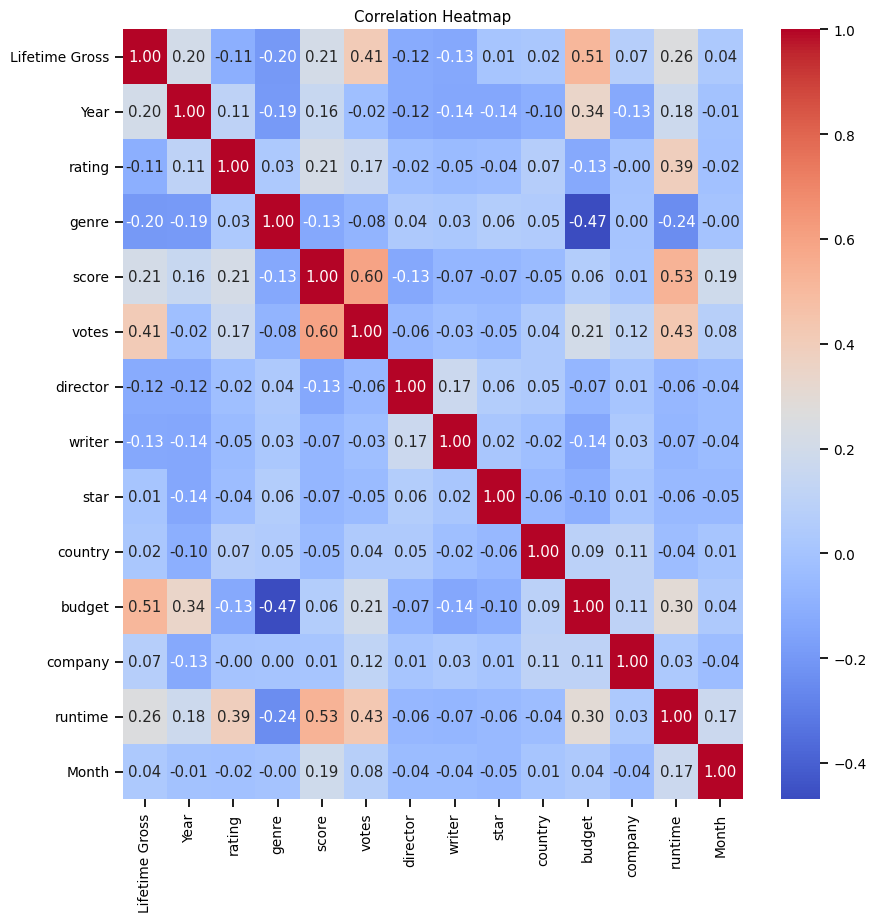

In [30]:
#drop some columns
temp_clean = unique_titles_df.drop(["gross", "IMDB Rating"], axis = 1)
temp_clean = temp_clean.drop(["director", "star", "writer", "company", "country", "Month", "genre"], axis = 1)
df2 = unique_titles_df.drop(["gross", "Title", "IMDB Rating"], axis = 1)

#label the non-numerical categories
le = LabelEncoder()
string_cat = ["genre", "director", "writer", "star", "company", "country"]
for cat in string_cat:
    df2[cat] = le.fit_transform(df2[cat]) 	

le.fit(df2['rating'])
le.classes_ = np.array(['Unknown', 'Not Rated', 'G', 'TV-PG', 'PG', 'PG-13', 'TV-MA', 'R'])
df2['rating'] = le.transform(df2['rating'])

#create correlation matrix
correlation_matrix = df2.corr()
correlation_matrix

# Set context for the plot
sns.set_context('notebook', font_scale=0.9)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the heatmap
sns.heatmap(ax=ax, data=correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')

plt.title('Correlation Heatmap')
plt.show()

Most correlated variables:

1) budget - 0.52
2) votes - 0.41
3) runtime - 0.26
4) score - 0.21

From this, we can infer that higher budget and votes correlates to higher lifetime gross. We will keep this in mind.

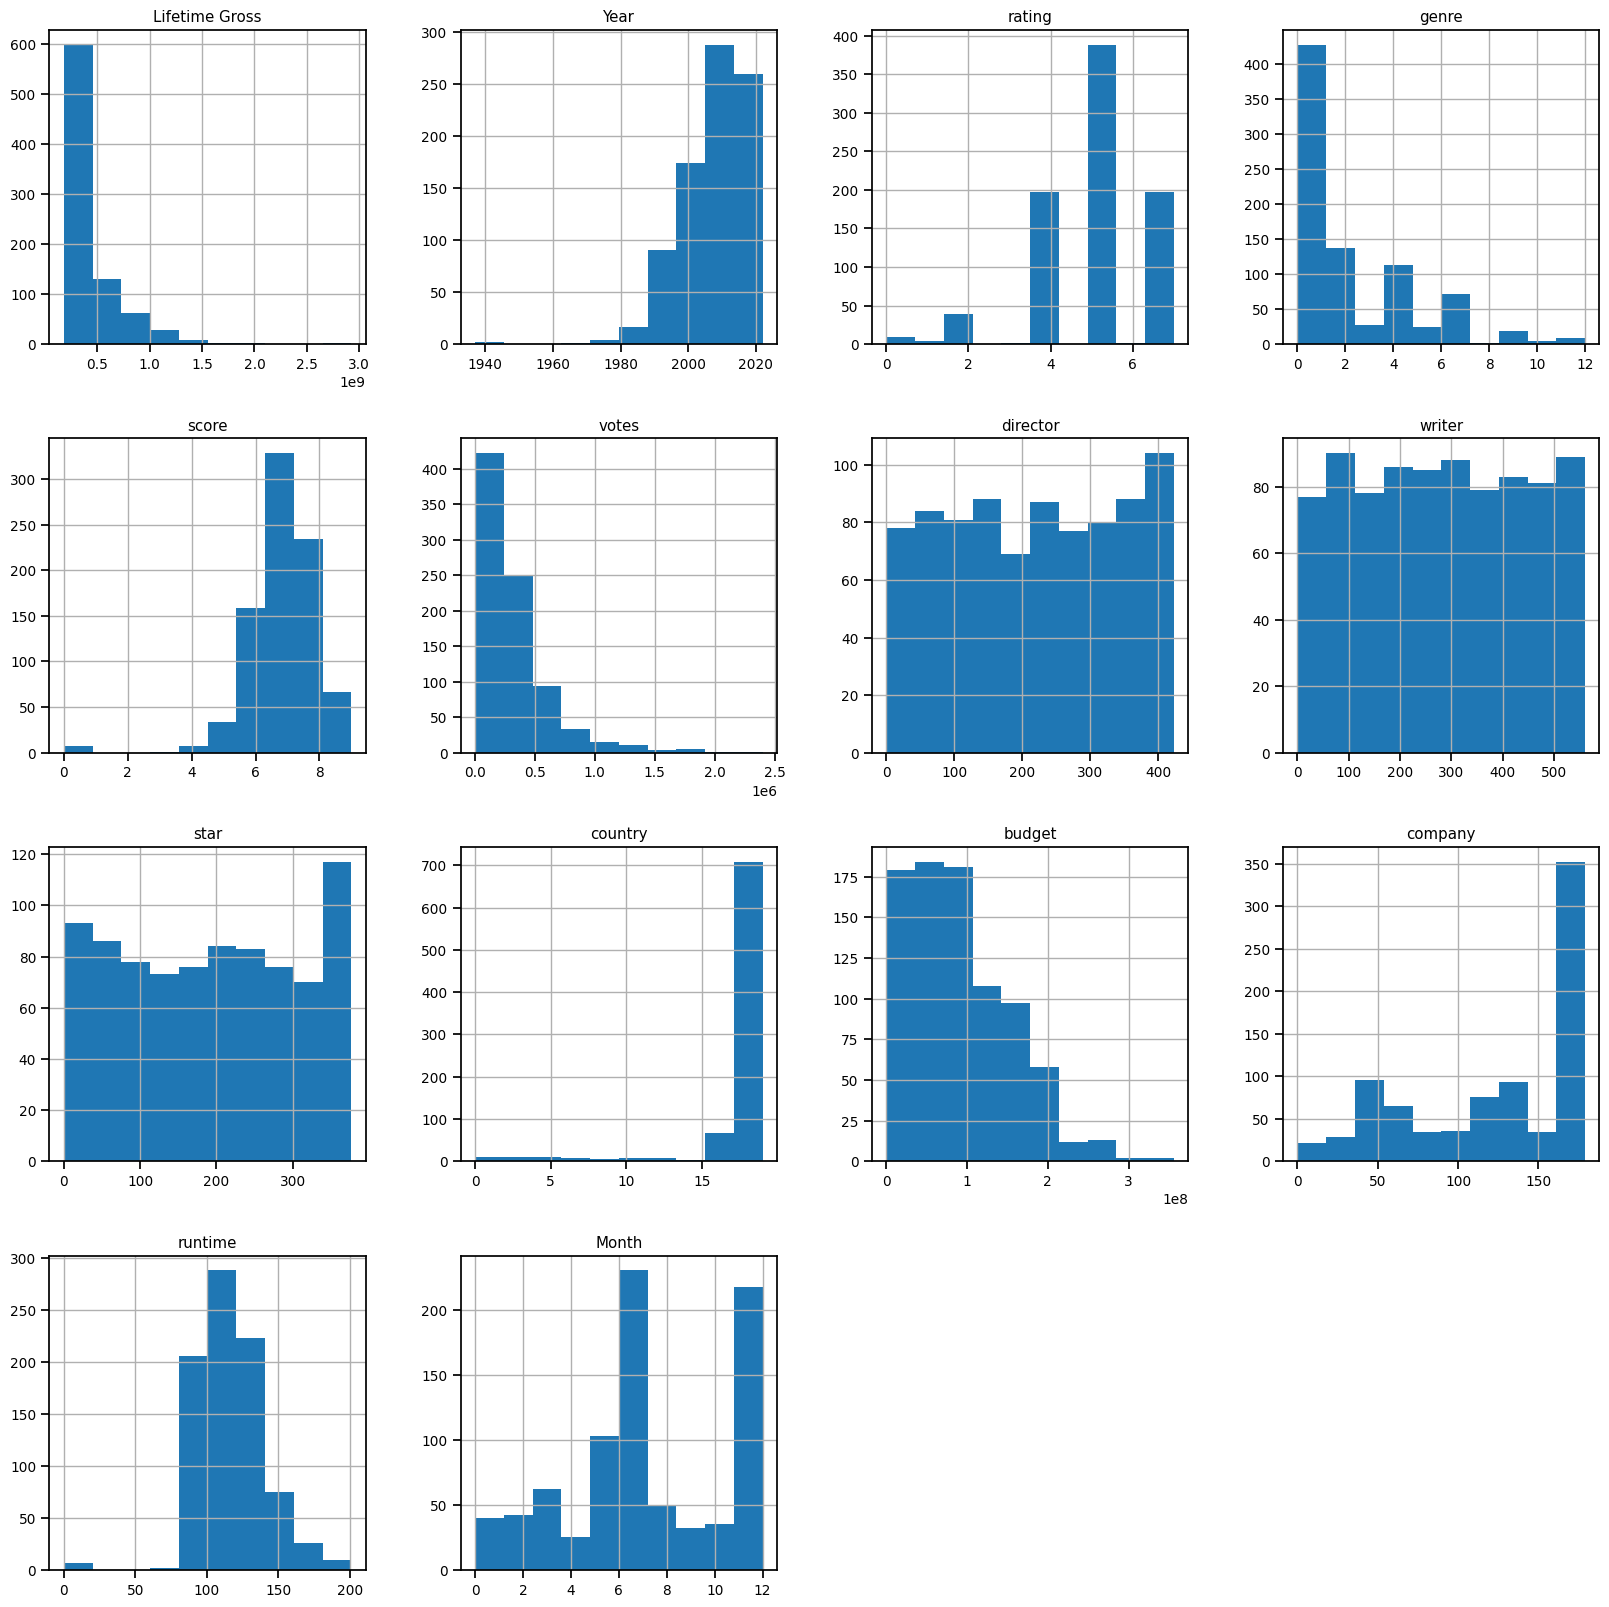

In [32]:
#plots the distributions
p = df2.hist(figsize=(20,20))


Standardization Justifications:
- Division by max keeps certain variables between 0-1
  - votes, rating, years_since_oldest, budget, score
  
We make it so all columns contain only numbers 0-1 representing how close they were to the max value within that column. This is because a feature like 'score' only goes up to 10 but a feature like 'budget' can be in the hundred millions. This standardization will make sure the model does not overly consider features that lend themselves to large values.

- Need to be dropped:
  - month, genre, director, star, writer, country, company
    

Some feature engineering: 
- Created new variable "years_since_oldest" that gives the number of years a film was released after the earliest film in the data and this column is divided by its max value to get values 0-1
- Since MPA film ratings go from Unknown - R, we can consider this a maturity scale see if how mature the content of a film is affect its box office performance. Rating was manually encoded in the previous section with this scale in mind


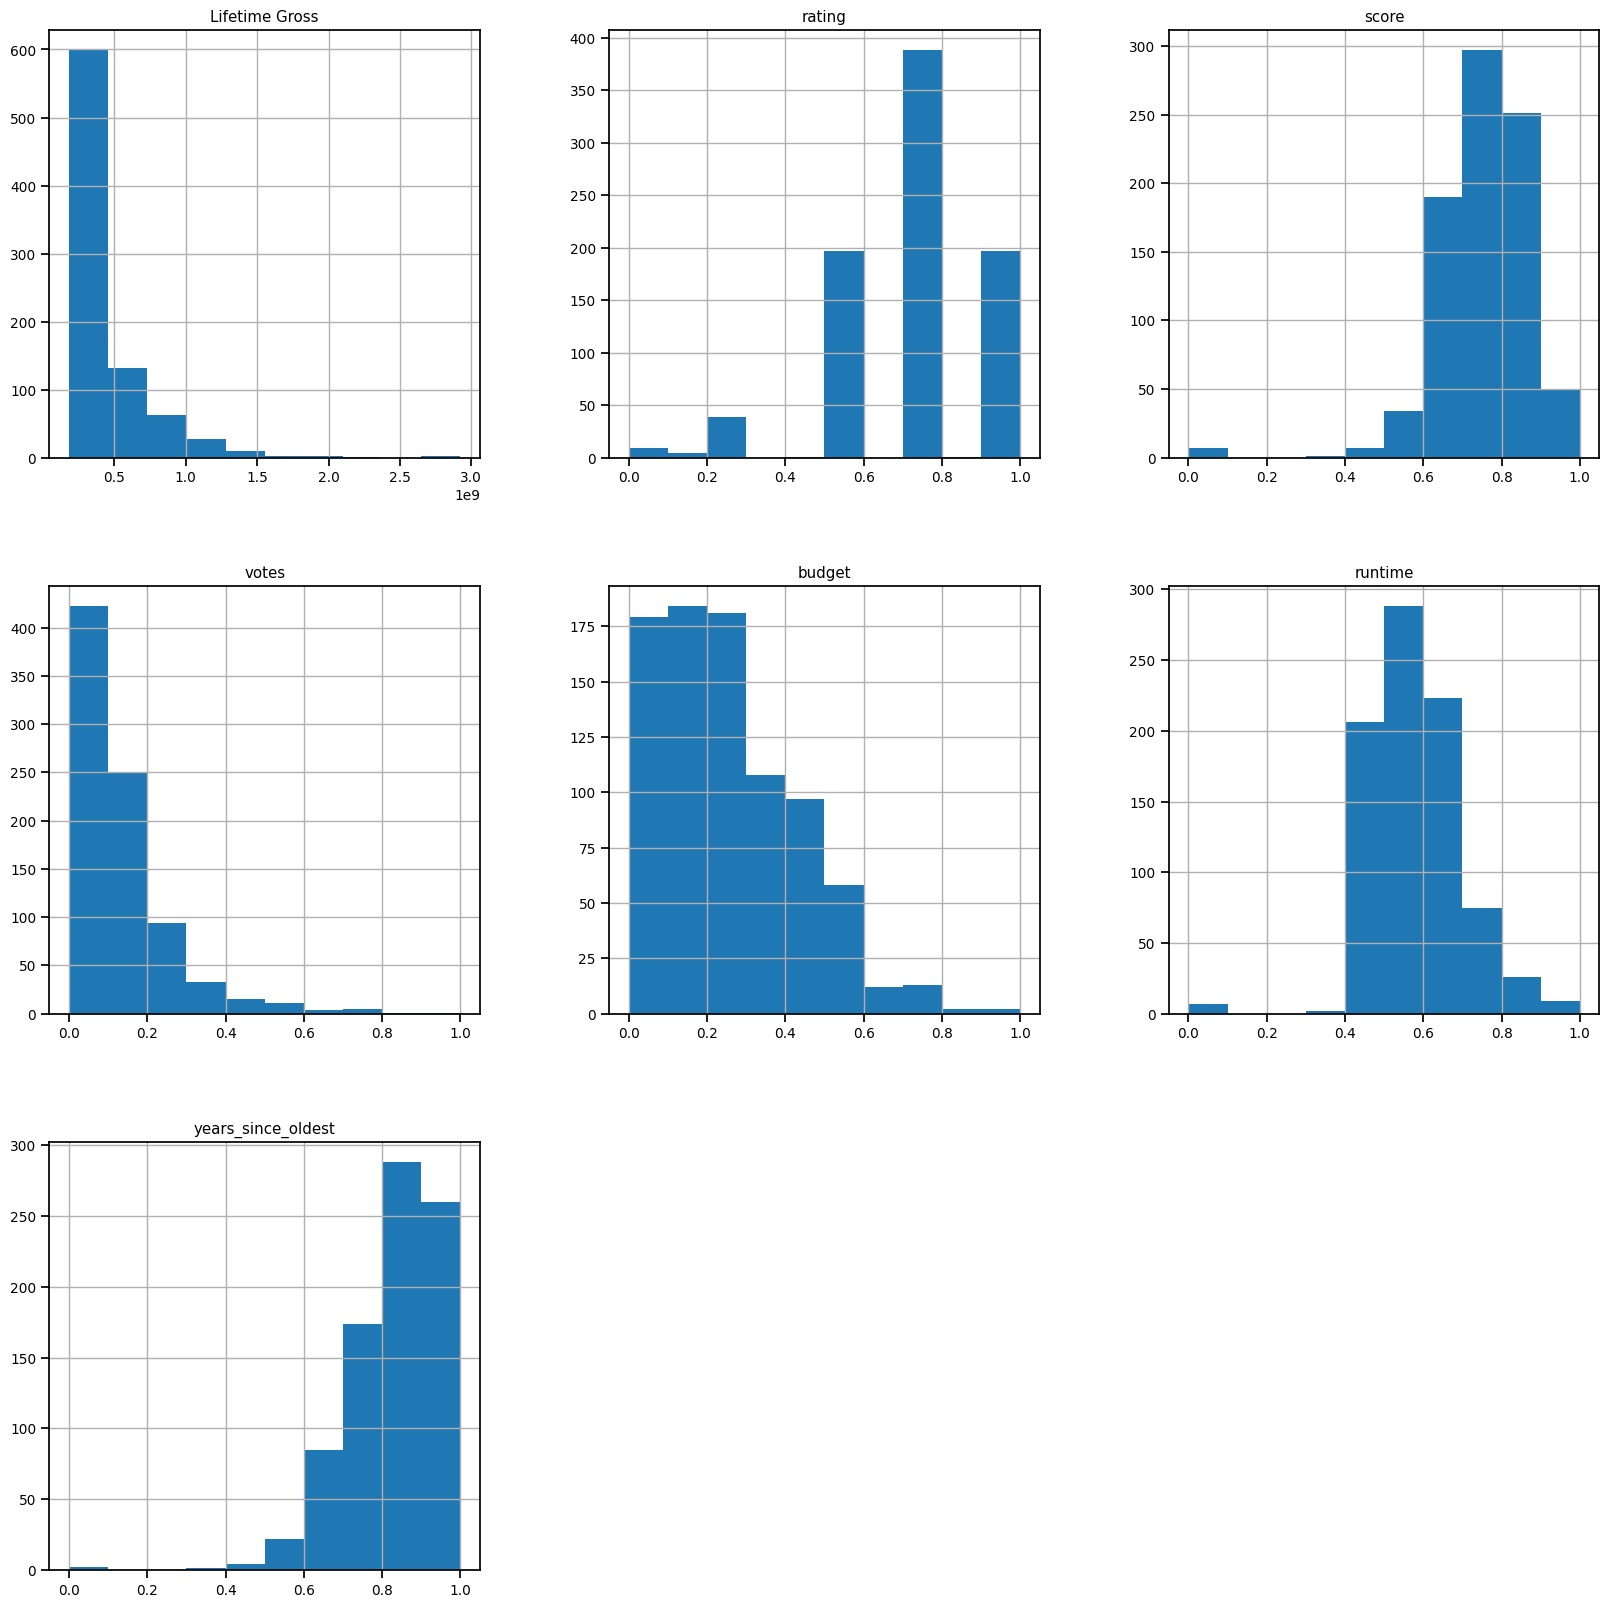

In [35]:
#standarize the data
temp_df = df2.drop(["director", "star", "writer", "company", "country", "Month", "genre"], axis = 1)

temp_df["years_since_oldest"] = temp_df["Year"] - temp_df["Year"].min()
temp_df = temp_df.drop("Year", axis = 1)
#max standardization
for col in ["votes", "runtime", "rating", "years_since_oldest", 'budget', 'runtime', 'score']:
    temp_df[col] = temp_df[col]/temp_df[col].max()

scalar_df = pd.DataFrame(temp_df, columns=temp_df.columns)

# plot the histograms
scalar_df.hist(figsize=(20, 20))
plt.show()

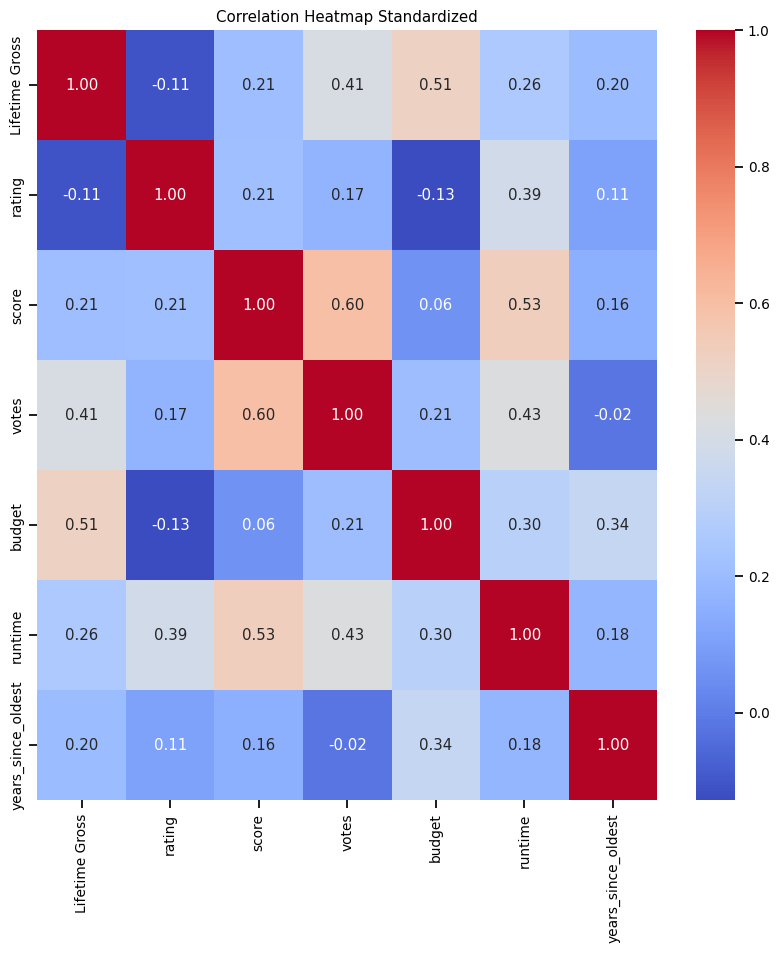

In [36]:
#create correlation matrix
correlation_matrix = scalar_df.corr()
correlation_matrix

# Set context for the plot
sns.set_context('notebook', font_scale=0.9)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the heatmap
sns.heatmap(ax=ax, data=correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')

plt.title('Correlation Heatmap Standardized')
plt.show()

Visualize correlation matrix with standardized variables. We observe that 'rating' is the least correlated variable with Lifetime Gross. This makes intuitive sense since the more mature a movie a rated, the less people would be able to watch it, thus we see a negative correlation where as a movie's rating becomes more mature, Lifetime gross decreases. This is helpful in figuring out which features are more important than others; we will try to derive a more sure-proof way of determining the best features to predict lifetime gross using machine learning algorithms to determine feature importance.


In [38]:
X = scalar_df.drop("Lifetime Gross", axis = 1)
y = df2["Lifetime Gross"]

#training and testing set (no validation?)
X_train_fi, X_test_fi, y_train_fi, y_test_fi = train_test_split(X, y, test_size = 0.2)

X_train_fi.shape

(668, 6)

In [39]:
#lasso for feature selection

#pipeline 
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

#test several a values
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

search.fit(X_train_fi,y_train_fi)

# check best alpha 
best_alpha = search.best_params_['model__alpha']
print("Best alpha:", best_alpha)

# coefficient of lasso
best_model = search.best_estimator_.named_steps['model']
coefficients = best_model.coef_
importance = np.abs(coefficients)

# print 
selected_features = X.columns[importance > 0]
non_selected_features = X.columns[importance == 0]
print("Selected Features:", selected_features)
print("Non-selected Features:", non_selected_features)


Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .model__alpha=0.1;, score=-62846544758341184.000 total time=   0.0s
[CV 2/5] END .model__alpha=0.1;, score=-49710337693426824.000 total time=   0.0s
[CV 3/5] END .model__alpha=0.1;, score=-67684171875912368.000 total time=   0.0s
[CV 4/5] END .model__alpha=0.1;, score=-71226919327784424.000 total time=   0.0s
[CV 5/5] END .model__alpha=0.1;, score=-44258058962199976.000 total time=   0.0s
[CV 1/5] END .model__alpha=0.2;, score=-62846544793571392.000 total time=   0.0s
[CV 2/5] END .model__alpha=0.2;, score=-49710337647510040.000 total time=   0.0s
[CV 3/5] END .model__alpha=0.2;, score=-67684171887256088.000 total time=   0.0s
[CV 4/5] END .model__alpha=0.2;, score=-71226919334528392.000 total time=   0.0s
[CV 5/5] END .model__alpha=0.2;, score=-44258058958724192.000 total time=   0.0s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-62846544828860648.000 total time=   0.0s
[CV 2/5] END model__alpha=0.3000

From using lasso coefficients for feature selection, we found out that all the features were chosen, and so every column had a non-zero importance value. This means that all the features that we have chosen until now were the right decision, as none of them is unimportant. However, this does not help us greatly; therefore, we will use feature importance to gather more insight on which features to use and which features to not use. 

In [41]:
def feature_importance(model, X_train, y_train):
    """
    use feature importance to determine feature importance scores, and plots the result

    Parameters:
    -----------
    model : user-supplied classifier
    X_train : X train dataset
    y_train : y train dataset

    """
    #fit with model
    model.fit(X_train, y_train)

    #determines the feature scores
    feature_scores = model.feature_importances_
    
    #sorts
    indices = np.argsort(feature_scores)

    #feature names
    features = X_train.columns

    #plot
    plt.title('Feature Importance')
    plt.barh(range(len(indices)), feature_scores[indices], color='r', align='center')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.show()



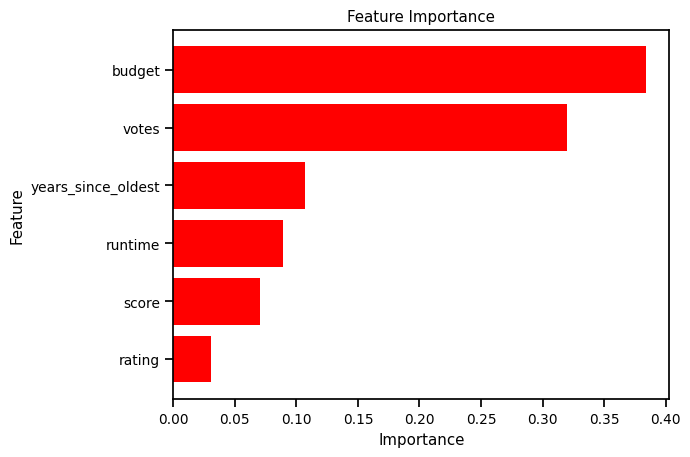

In [42]:
# create random forest regressor with n_estimators = 100

rfr = RandomForestRegressor(n_estimators=100, random_state=0) 
feature_importance(rfr, X_train_fi, y_train_fi)

The above plot confirms that the least important result is rating. This resulted in a slightly different result than the correlation matrix, but for the most part, it is pretty similar. Since rating has the lowest score in the correlation matrix and in the feature importance plot, it is safe to say that removing it will increase our model accuracy. However, we test it first to see if that hypothesis is true.

In [44]:
#dataframe without dropping rating column
rating_df = scalar_df.copy()

#dataframe with dropping rating column
scalar_df = scalar_df.drop("rating", axis=1)


#train test with rating column
X = rating_df.drop("Lifetime Gross", axis = 1)
y = rating_df["Lifetime Gross"]

#Get evaluation set (X_eval, y_eval)
X_training, X_eval, y_training, y_eval = train_test_split(X, y, test_size = 0.1)

#training and validation set
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size = 0.2)

X_train.shape
rating_df

,Lifetime Gross,rating,score,votes,budget,runtime,years_since_oldest
0,218843645.0,0.571429,0.811111,0.022500,0.050562,0.572139,0.964706
2,218791811.0,0.714286,0.866667,0.180000,0.154494,0.666667,0.894118
3,218613188.0,0.571429,0.788889,0.050833,0.196629,0.492537,0.717647
4,218340595.0,0.714286,0.777778,0.132083,0.168539,0.646766,0.882353
5,218237071.0,1.000000,0.800000,0.113333,0.365169,0.716418,0.800000
...,...,...,...,...,...,...,...
1037,585410052.0,0.714286,0.800000,0.293333,0.421348,0.502488,0.823529
1038,579723768.0,0.285714,0.900000,0.349167,0.323034,0.457711,0.752941
1048,574482479.0,0.571429,0.711111,0.134583,0.308989,0.537313,0.811765
1049,569651467.0,1.000000,0.455556,0.126667,0.112360,0.621891,0.917647


### Preliminary Model

In [46]:
def train_model(model, training_samples, test_samples, batch_size, epochs):
    """
    trains the model, then evaluate its performance on the test samples, 
    and then return the training history.

    Parameters:
    -----------
    model : user-supplied input
    training_samples : training images and labels (train_images, train_labels).
    test_samples : test images and labels (test_images, test_labels).
    batch_size : Batch size
    epochs : epoch size
    
    Returns:
    -------
    history : history containing loss and accuracy metrics.
    """
   # Separate images and labels
    train_images = training_samples[0]
    train_labels = training_samples[1]
    test_images = test_samples[0]
    test_labels = test_samples[1]

    # Define optimizer  
    adam = keras.optimizers.Adam(
        learning_rate=0.07,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    )

    
    # Define loss function and metric
    loss_fn = tf.keras.losses.MeanAbsolutePercentageError()
    mape = keras.metrics.MeanAbsolutePercentageError()

    # Compile model
    model.compile(optimizer=adam,
                  loss=loss_fn,
                  metrics=[mape])

    # Define early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model and return the history
    history = model.fit(train_images, train_labels, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(test_images, test_labels), 
                        verbose=False, 
                        callbacks=[early_stopping])
    return history


In [47]:
def test_model(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, X_eval = X_eval, y_eval = y_eval):
    """
    Use the current construct_fnn to make, train, and test models, 
       return the average and standard devation of ten tests.
       
    Returns:
    (average, sd), average and standard deviation of testing on unseen data.
    """
    
    eval_results = []
    for i in range(0,10):
        temp_model = construct_fnn(input_shape, output_shape)
        history = train_model(temp_model, (X_train, y_train), (X_test, y_test), 32, 75)
        eval_results.append(temp_model.evaluate(X_eval, y_eval, verbose=0)[0])
        
    average = np.array(eval_results).mean()
    sd = np.array(eval_results).std()
    
    return (average, sd)

In [48]:
def construct_fnn(input_shape, output_shape):
    '''
    construct a fully connected neural network

    Parameters
    ----------
    input_shape : user-supplied input shape
    output_shape : user-supplied output shape

    Returns
    -------
    the constructed model
    '''
    FNN_model = tf.keras.models.Sequential([
    layers.Dense(20, input_shape = (input_shape,), activation='relu', kernel_initializer='he_normal'),
    layers.Dense(20, activation='relu', kernel_initializer='he_normal'), 
    layers.Dense(output_shape)
    ],
    name = "pre_model",
    )
    return FNN_model

In [49]:
input_shape = 6
#output shape is 1 because of one label
output_shape = 1
#call the function
pre_model = construct_fnn(input_shape, output_shape)

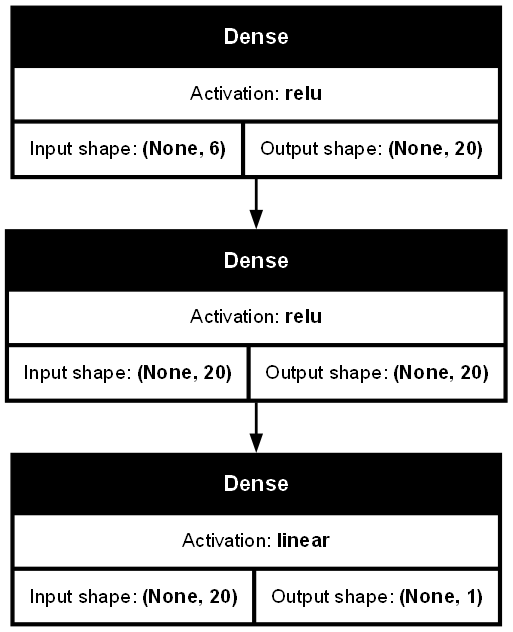

In [50]:
keras.utils.plot_model(pre_model, "premodel.png",
                      show_shapes=True,
                       show_layer_activations=True,
                       dpi = 100,
                        )

pre model with rating column

Batch size = 32, Epochs = 75 

Val MAPE on final epoch:
30.46867561340332 

Evaluation Results: 31.5728702545166


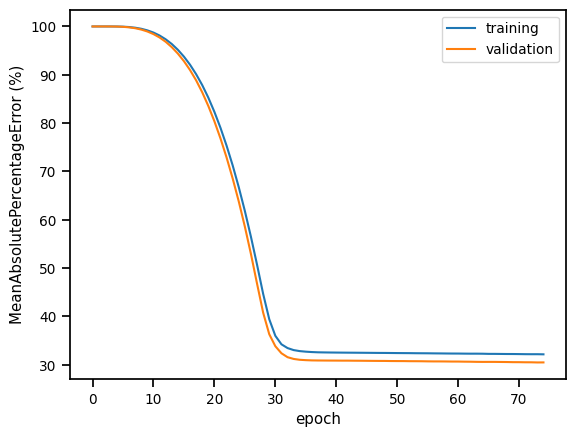

In [51]:
print('pre model with rating column\n')
print('Batch size = 32, Epochs = 75 \n')
history = train_model(pre_model, (X_train, y_train), (X_test, y_test), 32, 75)

# print out final validation MAPE
print("Val MAPE on final epoch:")
print(history.history["val_mean_absolute_percentage_error"][-1], "\n")

print("Evaluation Results:", pre_model.evaluate(X_eval, y_eval, verbose=0)[0])

plt.plot(history.history["loss"], label = "training")
plt.plot(history.history["val_loss"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "MeanAbsolutePercentageError (%)")
plt.legend()
plt.show()

In [52]:
print(test_model())

(31.597582244873045, 0.12981963596631438)


Our preliminary model gives us an average of 32.1% mean absolute percentage error with a standard deviation of ±0.07%

### Model Type 2

In [55]:
def train_model(model, training_samples, test_samples, batch_size, epochs):
    """
    trains the model, then evaluate its performance on the test samples, 
    and then return the training history.

    Parameters:
    -----------
    model : user-supplied input
    training_samples : training images and labels (train_images, train_labels).
    test_samples : test images and labels (test_images, test_labels).
    batch_size : Batch size
    epochs : epoch size
    
    Returns:
    -------
    history : history containing loss and accuracy metrics.
    """
   # Separate images and labels
    train_images = training_samples[0]
    train_labels = training_samples[1]
    test_images = test_samples[0]
    test_labels = test_samples[1]

    # Define optimizer  
    adam = keras.optimizers.Adam(
        learning_rate=0.003,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    )

    
    # Define loss function and metric
    loss_fn = tf.keras.losses.MeanAbsolutePercentageError()
    mape = keras.metrics.MeanAbsolutePercentageError()

    # Compile model
    model.compile(optimizer=adam,
                  loss=loss_fn,
                  metrics=[mape])

    # Define early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model and return the history
    history = model.fit(train_images, train_labels, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(test_images, test_labels), 
                        verbose=False, 
                        callbacks=[early_stopping])
    return history


In [56]:
def construct_fnn(input_shape, output_shape):
    '''
    construct a fully connected neural network

    Parameters
    ----------
    input_shape : user-supplied input shape
    output_shape : user-supplied output shape

    Returns
    -------
    the constructed model
    '''
    FNN_model = tf.keras.models.Sequential([
    layers.Dense(64, input_shape = (input_shape,), activation='relu', kernel_initializer='he_normal'),
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal'),

    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal'), 
    layers.Dense(64, activation='relu', kernel_initializer='he_normal'), 
    layers.Dense(output_shape)
    ],
    name = "FNN_Model_2",
    )
    return FNN_model

In [57]:
input_shape = 6
#output shape is 1 because of one label
output_shape = 1
#call the function
FNN_model = construct_fnn(input_shape, output_shape)

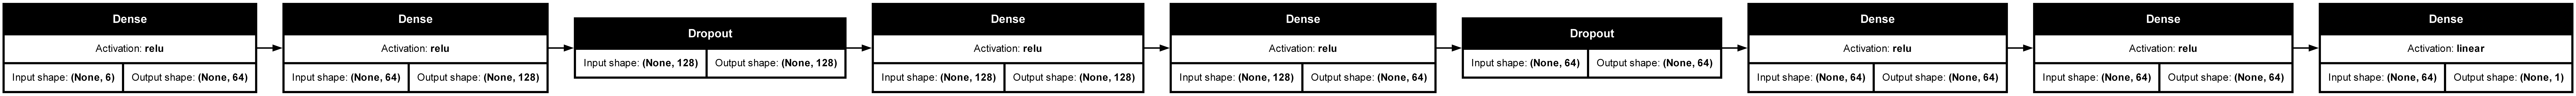

In [58]:
keras.utils.plot_model(FNN_model, "model_type2.png",
                      show_shapes=True,
                       show_layer_activations=True,
                       dpi = 800,
                       rankdir='LR'
                        )

FNN model with rating column

Batch size = 32, Epochs = 75 

Val MAPE on final epoch:
25.835346221923828 

Evaluation Results: 27.233205795288086


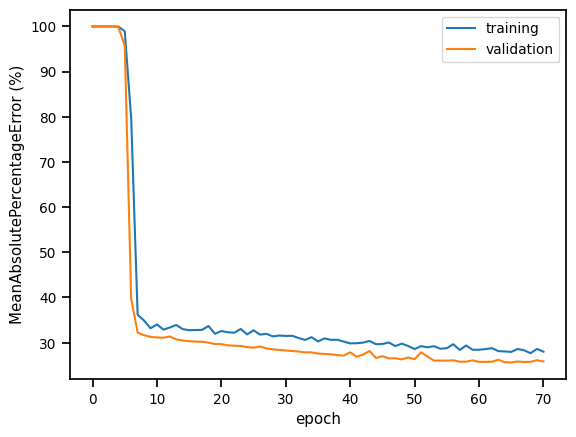

In [59]:
print('FNN model with rating column\n')
print('Batch size = 32, Epochs = 75 \n')
history = train_model(FNN_model, (X_train, y_train), (X_test, y_test), 32, 75)

# print out final validation MAPE
print("Val MAPE on final epoch:")
print(history.history["val_mean_absolute_percentage_error"][-1], "\n")

print("Evaluation Results:", FNN_model.evaluate(X_eval, y_eval, verbose=0)[0])

plt.plot(history.history["loss"], label = "training")
plt.plot(history.history["val_loss"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "MeanAbsolutePercentageError (%)")
plt.legend()
plt.show()

In [60]:
print(test_model())

(27.70592975616455, 0.16647508313151888)


### Model Type 3

Further experimentation with random search for hyperparameter tuning

Trial 10 Complete [00h 00m 21s]
val_loss: 100.0

Best val_loss So Far: 27.195545196533203
Total elapsed time: 00h 03m 22s
Best hyperparameters: 
{'num_layers': 4, 'units_0': 192, 'act_0': 'sigmoid', 'dropout_0': True, 'learning_rate': 0.01, 'dropout_rate_0': 0.30000000000000004, 'units_1': 160, 'act_1': 'relu', 'dropout_1': False, 'units_2': 256, 'act_2': 'relu', 'dropout_2': True, 'units_3': 416, 'act_3': 'relu', 'dropout_3': True, 'units_4': 416, 'act_4': 'sigmoid', 'dropout_4': False, 'units_5': 64, 'act_5': 'relu', 'dropout_5': True, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.30000000000000004, 'dropout_rate_3': 0.0}
Epoch 1/75


C:\Users\coolt\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 28.1091 - mean_absolute_percentage_error: 28.1091 - val_loss: 27.1567 - val_mean_absolute_percentage_error: 27.1567
Epoch 2/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.4267 - mean_absolute_percentage_error: 30.4267 - val_loss: 27.1187 - val_mean_absolute_percentage_error: 27.1187
Epoch 3/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.4018 - mean_absolute_percentage_error: 30.4018 - val_loss: 27.1291 - val_mean_absolute_percentage_error: 27.1291
Epoch 4/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.7669 - mean_absolute_percentage_error: 30.7669 - val_loss: 27.6835 - val_mean_absolute_percentage_error: 27.6835
Epoch 5/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.5445 - mean_absolute_percentage_error: 30.5445 - val_loss: 27.1588 - val_mean_absolute_percentage_error: 27.1588
Epoch 6/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.2358 - mean_absolute_percentage_error: 30.2358 - val_loss: 27.2897 - val_mean_a

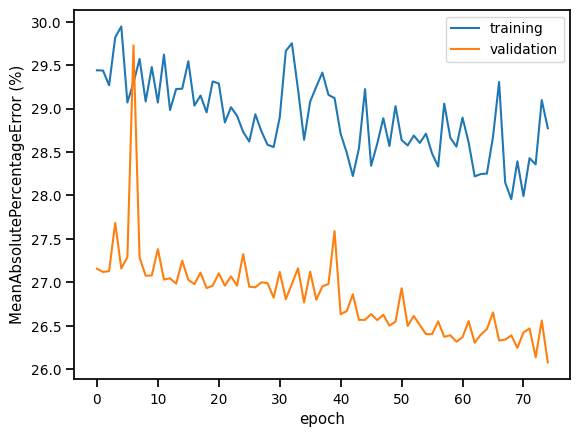

Evaluation Results: 27.56209945678711


In [63]:
def build_fnn_model(hp, input_shape, output_shape):
    '''
    build neural network using hyperparameter tuning with random search

    Parameters
    ----------
    hp : the hyperparameter object

    Returns
    -------
    the model
    
    '''
    model = keras.Sequential()
    
    # input layer
    model.add(layers.Input(shape=(input_shape,)))
    
    # hidden layers hyperparameter choices
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                               activation=hp.Choice(f'act_{i}', values=['relu', 'sigmoid'])))
        if hp.Boolean(f'dropout_{i}'):
            model.add(layers.Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.0, 0.5, step=0.1)))
    
    # output layer
    model.add(layers.Dense(output_shape, activation='linear'))

    # define loss function and metric
    loss_fn = tf.keras.losses.MeanAbsolutePercentageError()
    mape = keras.metrics.MeanAbsolutePercentageError()

    # compile model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss=loss_fn,
        metrics=[mape])
    
    return model

input_shape = 6
output_shape = 1

# keras tuner
tuner = kt.RandomSearch(
    lambda hp : build_fnn_model(hp, input_shape, output_shape),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='fnn_tuning'
)

# search for best hyperparameter with dataset
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# obtain best model
best_fnn_model = tuner.get_best_models(num_models=1)[0]

# print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters: ")
print(best_hyperparameters.values)
# train with best hyperparameters
history = best_fnn_model.fit(X_train, y_train, epochs=75, batch_size=32, validation_data=(X_test, y_test))

# on final epoch
print("Val MAPE on final epoch:")
print(history.history["val_mean_absolute_percentage_error"][-1])

# plot 
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.gca().set(xlabel="epoch", ylabel="MeanAbsolutePercentageError (%)")
plt.legend()
plt.show()

# evaluation results
evaluation_results = best_fnn_model.evaluate(X_eval, y_eval, verbose=0)
print("Evaluation Results:", evaluation_results[0])


The best hyperparameters found by Keras Tuner indicate the optimal configuration for the neural network based on random search, and the results gave us the best hyperparameters with the values of 4 as the number of hidden layers, where each of the 4 hidden layers ahve 32 units, the activation function is ReLu, no dropout layers are used, and the learning rate is 0.01. The evaluation results gave us about 28-31% consistently, which scored lower than Model 2, but looking at the plot, we can see that there is no fluctuations, meaning that even without dropout layers, the model made sure to not overfit. We can hypothesize that we are approaching the best results we can acheive given our data and data processing.

Also, we decided to use xgboost and stacking technique to see if that can get us a better result.

In [66]:
import xgboost as xgb

model_params = {
    'objective': 'reg:squarederror',  # squared error for regression
    'eval_metric': 'rmse',  # root mean squared error for evaluation
    'max_depth': 7,  # maximum depth of decision trees
    'n_estimators': 100,  # number of boosting stages
    'learning_rate': 0.1,  # learning rate for gradient boosting
    'early_stopping_rounds' : 5,
}

#xgb regressor model
model = xgb.XGBRegressor(**model_params)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Make predictions on the test set
y_pred = model.predict(X_eval)

# Evaluate the model performance with MAPE
mape = np.mean(np.abs((y_pred - y_eval) / (np.abs(y_eval) + 1e-7)))

print(f"MAPE on test set: {mape}")

[0]	validation_0-rmse:242751318.09041
[1]	validation_0-rmse:230452250.00895
[2]	validation_0-rmse:219435636.75911
[3]	validation_0-rmse:210487615.96375
[4]	validation_0-rmse:201850662.30860
[5]	validation_0-rmse:195653535.66651
[6]	validation_0-rmse:191033643.96264
[7]	validation_0-rmse:187929199.87950
[8]	validation_0-rmse:183790248.47241
[9]	validation_0-rmse:182579133.13394
[10]	validation_0-rmse:181824804.36340
[11]	validation_0-rmse:181362811.44223
[12]	validation_0-rmse:179929847.10587
[13]	validation_0-rmse:180091972.95777
[14]	validation_0-rmse:178973415.56713
[15]	validation_0-rmse:179364068.19366
[16]	validation_0-rmse:179903422.99225
[17]	validation_0-rmse:179624771.92329
[18]	validation_0-rmse:178330533.91586
[19]	validation_0-rmse:178387867.44046
[20]	validation_0-rmse:177618162.25401
[21]	validation_0-rmse:177567941.31051
[22]	validation_0-rmse:178223948.90797
[23]	validation_0-rmse:178116987.50123
[24]	validation_0-rmse:179044994.84998
[25]	validation_0-rmse:178664793.37

In [67]:
#stacking technique 

# base models
base_models = [
    ('ridge', Ridge(alpha=1.0)),
    ('tree', DecisionTreeRegressor(random_state=42)),
    ('svm', SVR(kernel='linear'))
]

# meta model
meta_model = Lasso(alpha=0.1)

# stacking
stacking = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# fit stacking
stacking.fit(X_train, y_train)

# prediction
y_pred_stacking = stacking.predict(X_test)
mape= mean_absolute_percentage_error(y_test, y_pred_stacking)
print("Mean Absolute Percentage Error Stacking:", mape)


Mean Absolute Percentage Error Stacking: 0.35922952360496085


C:\Users\coolt\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e+19, tolerance: 5.896e+15
  model = cd_fast.enet_coordinate_descent(


The stacking method which is a technique in ensemble modeling, which trains multiple base models and uses their predictions as input features, gave us a worser result, so our hypothesis is that our dataset works better with neural networks than ensemble modeling. The xgb boost also gave us a worser result than our fully connected neural network. 

### Without 'rating' column

Let's check if the least correlated variable 'rating', does really have an effect on the accuracy of the model.

FNN model without rating column 

Batch size = 32, Epochs = 75 

Val MAPE on final epoch:
32.708736419677734 

Evaluation Results: 33.15699005126953


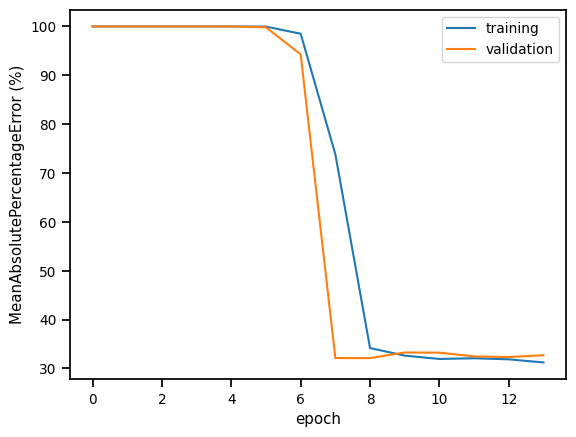

In [71]:
#input shape is 5 because 5 features
input_shape = 5
#output shape is 1 because of one label
output_shape = 1

X_no_rating = scalar_df.drop("Lifetime Gross", axis = 1)
y_no_rating = scalar_df["Lifetime Gross"]

#Get evaluation set (X_eval, y_eval)
X_training2, X_eval2, y_training2, y_eval2 = train_test_split(X_no_rating, y_no_rating, test_size = 0.1)

#training and validation set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_training2, y_training2, test_size = 0.2)

print('FNN model without rating column \n')
print('Batch size = 32, Epochs = 75 \n')

FNN_model2 = construct_fnn(input_shape, output_shape)
history = train_model(FNN_model2, (X_train2, y_train2), (X_test2, y_test2), 32, 75)

# print out final validation MAPE
print("Val MAPE on final epoch:")
print(history.history["val_mean_absolute_percentage_error"][-1], "\n")

print("Evaluation Results:", FNN_model2.evaluate(X_eval2, y_eval2, verbose=0)[0])
plt.plot(history.history["loss"], label = "training")
plt.plot(history.history["val_loss"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "MeanAbsolutePercentageError (%)")
plt.legend()
plt.show()

In [72]:
print(test_model(X_train = X_train2, y_train = y_train2, X_test = X_test2, y_test = y_test2, X_eval = X_eval2, y_eval = y_eval2))

(32.034843826293944, 0.24372390156908014)


Removing the least correlated and only negatively correlated feature in 'rating' did not result in better performance. The model without the 'rating' feature averages around 1-2% greater mean absolute percentage error than when 'rating' is included. Even after removing features with low scores in correlation matrix and feature importance, the model did not perform better, and this indicates that there are several potential reasons for this. One potential reason can be information loss. Some features might not be important on their own but could be important in combination with other features. Therefore, removing the less important features might have disrupted the correlations between the features, leading to a worse result. 

Trial 10 Complete [00h 00m 30s]
val_loss: 99.50020599365234

Best val_loss So Far: 87.25438435872395
Total elapsed time: 00h 03m 50s
Best hyperparameters: 
{'num_layers': 4, 'units_0': 96, 'act_0': 'sigmoid', 'dropout_0': True, 'learning_rate': 0.001, 'dropout_rate_0': 0.0, 'units_1': 384, 'act_1': 'sigmoid', 'dropout_1': True, 'units_2': 224, 'act_2': 'relu', 'dropout_2': True, 'units_3': 288, 'act_3': 'relu', 'dropout_3': False, 'units_4': 64, 'act_4': 'relu', 'dropout_4': False, 'dropout_rate_2': 0.4, 'dropout_rate_1': 0.0}
Epoch 1/75


C:\Users\coolt\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 87.1707 - mean_absolute_percentage_error: 87.1707 - val_loss: 86.2406 - val_mean_absolute_percentage_error: 86.2406
Epoch 2/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86.1922 - mean_absolute_percentage_error: 86.1922 - val_loss: 85.7828 - val_mean_absolute_percentage_error: 85.7828
Epoch 3/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86.3535 - mean_absolute_percentage_error: 86.3535 - val_loss: 85.3110 - val_mean_absolute_percentage_error: 85.3110
Epoch 4/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 85.7890 - mean_absolute_percentage_error: 85.7890 - val_loss: 84.8250 - val_mean_absolute_percentage_error: 84.8250
Epoch 5/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 85.2126 - mean_absolute_percentage_error: 85.2126 - val_loss: 84.3193 - val_mean_absolute_percentage_error: 84.3193
Epoch 6/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 84.9686 - mean_absolute_percentage_error: 84.9686 - val_loss: 83.8000 - val_mean_a

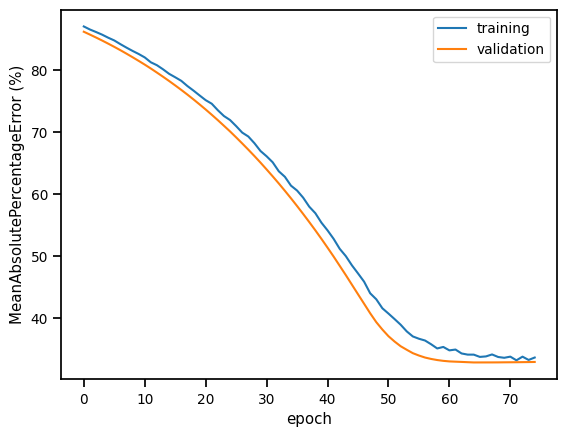

Evaluation Results: 33.32376480102539


In [74]:
#input, output shape
input_shape = X_train2.shape[1]
output_shape = 1

# keras tuner
tuner = kt.RandomSearch(
    lambda hp : build_fnn_model(hp, input_shape, output_shape),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir2',
    project_name='fnn_tuning'
)

# search for best hyperparameter with dataset
tuner.search(X_train2, y_train2, epochs=50, validation_data=(X_test2, y_test2))

# obtain best model
best_fnn_model = tuner.get_best_models(num_models=1)[0]

# print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters: ")
print(best_hyperparameters.values)

# train with best hyperparameters
history = best_fnn_model.fit(X_train2, y_train2, epochs=75, batch_size=32, validation_data=(X_test2, y_test2))

# on final epoch
print("Val MAPE on final epoch:")
print(history.history["val_mean_absolute_percentage_error"][-1])

# plot 
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.gca().set(xlabel="epoch", ylabel="MeanAbsolutePercentageError (%)")
plt.legend()
plt.show()

# evaluation results
evaluation_results = best_fnn_model.evaluate(X_eval2, y_eval2, verbose=0)
print("Evaluation Results:", evaluation_results[0])

The results with the hyperparameter tuning gave us a result of around 30-32% MAPE, which performed a little worse than our custom model.  

In [76]:
import xgboost as xgb

model_params = {
    'objective': 'reg:squarederror',  # squared error for regression
    'eval_metric': 'rmse',  # root mean squared error for evaluation
    'max_depth': 7,  # maximum depth of decision trees
    'n_estimators': 100,  # number of boosting stages
    'learning_rate': 0.1,  # learning rate for gradient boosting
    'early_stopping_rounds' : 5,
}

#xgb regressor model
model = xgb.XGBRegressor(**model_params)
model.fit(X_train2, y_train2, eval_set=[(X_test2, y_test2)])

# Make predictions on the test set
y_pred = model.predict(X_eval2)

# Evaluate the model performance with MAPE
mape = np.mean(np.abs((y_pred - y_eval2) / (np.abs(y_eval2) + 1e-7)))

print(f"MAPE on unseen test set: {mape}")

[0]	validation_0-rmse:250112021.52452
[1]	validation_0-rmse:244563625.94170
[2]	validation_0-rmse:239428450.69036
[3]	validation_0-rmse:236046341.62906
[4]	validation_0-rmse:232555758.29052
[5]	validation_0-rmse:230510512.54574
[6]	validation_0-rmse:228122902.50271
[7]	validation_0-rmse:226643599.20154
[8]	validation_0-rmse:225548390.28317
[9]	validation_0-rmse:224175416.58363
[10]	validation_0-rmse:224145797.78275
[11]	validation_0-rmse:223622776.12301
[12]	validation_0-rmse:223511486.85809
[13]	validation_0-rmse:223873392.05136
[14]	validation_0-rmse:223143201.06582
[15]	validation_0-rmse:223416401.04231
[16]	validation_0-rmse:222985561.75253
[17]	validation_0-rmse:223100648.22302
[18]	validation_0-rmse:223204685.45622
[19]	validation_0-rmse:222946773.95113
[20]	validation_0-rmse:222703538.56681
[21]	validation_0-rmse:222756767.45680
[22]	validation_0-rmse:223106899.68645
[23]	validation_0-rmse:223668572.15032
[24]	validation_0-rmse:223947528.54780
[25]	validation_0-rmse:223642228.27

### Model Comparison
- Lets compare our NN models to ML regression models from Scikit-Learn

Mean Absolute Percentage Error Linear Regression: 0.376196036771495


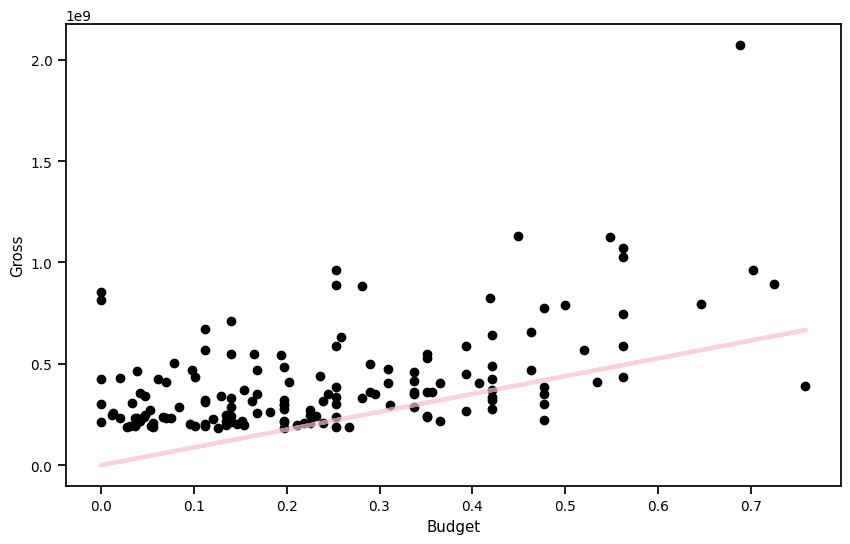

In [78]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_lm_pred = lm.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_lm_pred)
print("Mean Absolute Percentage Error Linear Regression:", mape)


coeff = lm.coef_

fig, ax = plt.subplots(1, figsize = (10,6))
plt.scatter(X_test['budget'], y_test, color="black")
plt.plot(X_test['budget'], X_test['budget']*coeff[2], color="pink", linewidth=3, alpha = 0.7)

ax.set_xlabel("Budget")
ax.set_ylabel("Gross")
plt.show()

In [79]:
Cval = 100
eps= 1

SVRreg = SVR(C=Cval, epsilon=eps)
SVRreg.fit(X_train,y_train)
y_SVR_pred = SVRreg.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_SVR_pred)
print("Mean Absolute Percentage Error for SVR with rbf kernel:", mape)   

SVRreg2 = SVR(C=Cval, epsilon=eps, kernel = "linear")
SVRreg2.fit(X_train,y_train)
y_SVR_pred = SVRreg2.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_SVR_pred)
print("Mean Absolute Percentage Error for SVR with linear kernel:", mape)   

SVRreg3 = SVR(C=Cval, epsilon=eps, kernel = "sigmoid")
SVRreg3.fit(X_train,y_train)
y_SVR_pred = SVRreg3.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_SVR_pred)
print("Mean Absolute Percentage Error for SVR with sigmoid kernel:", mape)   

Mean Absolute Percentage Error for SVR with rbf kernel: 0.35768356322117567
Mean Absolute Percentage Error for SVR with linear kernel: 0.35768727302579933
Mean Absolute Percentage Error for SVR with sigmoid kernel: 0.3576898942682284


In [80]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, rf_pred)
print("Mean Absolute Percentage Error Random Forest:", mape)

Mean Absolute Percentage Error Random Forest: 0.31383797129909224


Our model does a bit better than the sklearn models defined above. 

Since we are working with a Linear Regression problem in trying to predict film gross, we are happy to see that our NN can perform a bit better than the sklearn Linear Regression model

### Improvements for the future

While our custom neural network perfomed better compared to some of the sklearn models, it is nowhere near perfect. The limitations of the model perfoming better can be because of failing to determine better features in predicting lifetime gross. It is possible that features not included in our dataset plays a big part in determining the movie success, such as the economy of when the movie was released, competition in the market, and marketing, which is difficult to quantify. The movie industry itself is difficult to predict because of that, and the specific features such as the runtime, number of votes, etc, might not be sufficient enough. Another error that could have occured that hindered our result could have been the mismatch between our features and our model. We dropped many features that seemed to not have strong correlation with lifetime gross. Because of that, we were left with only several columns, and the model might have perfomed better with more amounts of features. 

Our data size is very small with less than 1,000 columns so we hypothesize that more data will lead to better training results.

The papers we have referenced in working on our project actually use classifications and partition film gross, the target variable, into classes of ranges of values.

### Additional Data

In [86]:
#the additional datas
TMDB = "https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies"
od.download(TMDB)
tmdb = "./tmdb-movies-dataset-2023-930k-movies"
full_tmdb = pd.read_csv(os.path.join(tmdb, 'TMDB_movie_dataset_v11.csv'))

#Data cleaning
full_tmdb["Title"] = full_tmdb["title"]
full_tmdb["votes"] = full_tmdb["vote_count"]
full_tmdb["score"] = full_tmdb["vote_average"]
full_tmdb["Lifetime Gross"] = full_tmdb["revenue"]
full_tmdb = full_tmdb[["Title", "score", "runtime", "budget", "votes", "release_date", "Lifetime Gross"]]
full_tmdb = full_tmdb.dropna()
full_tmdb = full_tmdb[~(full_tmdb[full_tmdb.columns[:]] == 0).any(axis=1)]
full_tmdb["Year"] = (full_tmdb["release_date"]).str.slice(0, 4)
full_tmdb = full_tmdb.drop("release_date", axis = 1)
full_tmdb

Skipping, found downloaded files in ".\tmdb-movies-dataset-2023-930k-movies" (use force=True to force download)


,Title,score,runtime,budget,votes,Lifetime Gross,Year
0,Inception,8.364,148,160000000,34495,825532764,2010
1,Interstellar,8.417,169,165000000,32571,701729206,2014
2,The Dark Knight,8.512,152,185000000,30619,1004558444,2008
3,Avatar,7.573,162,237000000,29815,2923706026,2009
4,The Avengers,7.710,143,220000000,29166,1518815515,2012
...,...,...,...,...,...,...,...
346436,Guru Dakshina,8.000,147,6473,1,9062,1987
347047,Science Please! : The Wonderful World of Colour,10.000,1,100270,1,100270,1999
347284,White Stare,10.000,98,702,1,18,2024
347298,Nanna & Lil' Puss Puss in 'Who Calcutta the Ch...,10.000,3,15107,1,15107,1993


In [87]:
#Check the mean
full_tmdb["Lifetime Gross"].mean()

64909039.00455868

In [88]:
temp_clean

,Title,Lifetime Gross,Year,rating,score,votes,budget,runtime
0,Little Women,218843645.0,2019.0,PG,7.3,54000.0,18000000.0,115.0
2,Captain Phillips,218791811.0,2013.0,PG-13,7.8,432000.0,55000000.0,134.0
3,The Prince of Egypt,218613188.0,1998.0,PG,7.1,122000.0,70000000.0,99.0
4,Jack Reacher,218340595.0,2012.0,PG-13,7.0,317000.0,60000000.0,130.0
5,Kingdom of Heaven,218237071.0,2005.0,R,7.2,272000.0,130000000.0,144.0
...,...,...,...,...,...,...,...,...
1037,I Am Legend,585410052.0,2007.0,PG-13,7.2,704000.0,150000000.0,101.0
1038,"Monsters, Inc.",579723768.0,2001.0,G,8.1,838000.0,115000000.0,92.0
1048,Night at the Museum,574482479.0,2006.0,PG,6.4,323000.0,110000000.0,108.0
1049,Fifty Shades of Grey,569651467.0,2015.0,R,4.1,304000.0,40000000.0,125.0


In [89]:
#Data cleaing
new_df = pd.concat([temp_clean, full_tmdb])
new_df = new_df.drop("rating", axis = 1)
new_df = new_df.drop_duplicates()

In [90]:
gross_mask = new_df['Lifetime Gross'] < 10000000

In [91]:
new_df = new_df[~gross_mask]

In [92]:
new_df['Lifetime Gross'].mean()

159551720.55483666

In [93]:
new_df["Year"] = new_df["Year"].astype("int")
new_df["years_since_oldest"] = new_df["Year"] - new_df["Year"].min()
new_df = new_df.drop("Year", axis = 1)

#max standardization
for col in ["votes", "runtime", "years_since_oldest", 'budget', 'runtime', 'score']:
    new_df[col] = new_df[col]/new_df[col].max()

new_df = pd.DataFrame(new_df, columns=new_df.columns)

In [94]:
X_new = new_df.drop(["Title", "Lifetime Gross"], axis = 1)
y_new = new_df["Lifetime Gross"]

#only train with a batch of 1/3 of the new data
X_batch, X_reserve, y_batch, y_reserve = train_test_split(X_new, y_new, test_size = 0.3)

X_training3, X_eval3, y_training3, y_eval3 = train_test_split(X_batch, y_batch, test_size = 0.3)

#training and validation set
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_training3, y_training3, test_size = 0.3)


In [95]:
X_training3

,score,votes,budget,runtime,years_since_oldest
6187,0.7305,0.000219,0.002174,0.233333,0.926606
3594,0.5553,0.000469,0.195652,0.170370,0.761468
3034,0.5907,0.000571,0.054348,0.187037,0.844037
8058,0.6800,0.000148,0.097826,0.207407,0.990826
2387,0.7000,0.000748,0.018478,0.179630,0.660550
...,...,...,...,...,...
17937,0.5426,0.000043,0.004348,0.140741,0.642202
180,0.7437,0.005099,0.206522,0.300000,0.954128
192,0.6600,0.098750,0.282609,0.272222,0.807339
7844,0.6061,0.000155,0.043478,0.172222,0.715596


In [96]:
def train_model(model, training_samples, test_samples, batch_size, epochs):
    """
    trains the model, then evaluate its performance on the test samples, 
    and then return the training history.

    Parameters:
    -----------
    model : user-supplied input
    training_samples : training images and labels (train_images, train_labels).
    test_samples : test images and labels (test_images, test_labels).
    batch_size : Batch size
    epochs : epoch size
    
    Returns:
    -------
    history : history containing loss and accuracy metrics.
    """
   # Separate images and labels
    train_images = training_samples[0]
    train_labels = training_samples[1]
    test_images = test_samples[0]
    test_labels = test_samples[1]

    # Define optimizer  
    adam = keras.optimizers.Adam(
        learning_rate=0.03,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    )

    
    # Define loss function and metric
    loss_fn = keras.losses.MeanAbsolutePercentageError()
    mape = keras.metrics.MeanAbsolutePercentageError()

    # Compile model
    model.compile(optimizer=adam,
                  loss=loss_fn,
                  metrics=[mape])

    # Define early stopping callback
    #early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model and return the history
    history = model.fit(train_images, train_labels, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(test_images, test_labels), 
                        verbose=False, 
                      #  callbacks=[early_stopping]
                       )
    return history

In [97]:
#introduce regularization
from keras.regularizers import L1

In [98]:
def construct_fnn(input_shape, output_shape):
    '''
    construct a fully connected neural network

    Parameters
    ----------
    input_shape : user-supplied input shape
    output_shape : user-supplied output shape

    Returns
    -------
    the constructed model
    '''
    FNN_model = keras.models.Sequential([
    layers.Dense(258, input_shape = (input_shape,), activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.2),
    layers.Dense(258, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.2),
    layers.Dense(258, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.1),
    layers.Dense(output_shape)
    ],
    name = "FNN_Model",
    )
    return FNN_model

FNN model without rating column 

Batch size = 32, Epochs = 75 

Val MAPE on final epoch:
55.780818939208984 

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 53.7491 - mean_absolute_percentage_error: 53.7491
Evaluation Results: 53.6591911315918


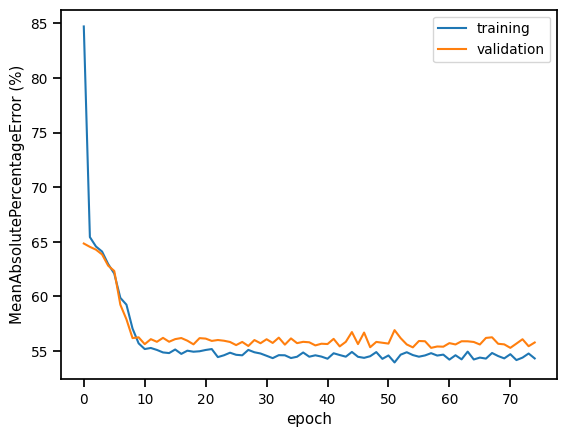

In [99]:
print('FNN model without rating column \n')
print('Batch size = 32, Epochs = 75 \n')

input_shape = 5
output_shape = 1

FNN_model3 = construct_fnn(input_shape, output_shape)
history = train_model(FNN_model3, (X_train3, y_train3), (X_test3, y_test3), 32, 75)

# print out final validation MAPE
print("Val MAPE on final epoch:")
print(history.history["val_mean_absolute_percentage_error"][-1], "\n")

print("Evaluation Results:", FNN_model3.evaluate(X_eval3, y_eval3, verbose=1)[0])
plt.plot(history.history["loss"], label = "training")
plt.plot(history.history["val_loss"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "MeanAbsolutePercentageError (%)")
plt.legend()
plt.show()

Trial 10 Complete [00h 00m 35s]
val_loss: 99.97265879313152

Best val_loss So Far: 54.55846150716146
Total elapsed time: 00h 06m 29s
Best hyperparameters: 
{'num_layers': 5, 'units_0': 160, 'act_0': 'sigmoid', 'dropout_0': True, 'learning_rate': 0.01, 'units_1': 96, 'act_1': 'relu', 'dropout_1': False, 'units_2': 320, 'act_2': 'relu', 'dropout_2': False, 'dropout_rate_0': 0.0, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.30000000000000004, 'units_3': 320, 'act_3': 'relu', 'dropout_3': False, 'units_4': 32, 'act_4': 'relu', 'dropout_4': False}
Epoch 1/75


C:\Users\coolt\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 52.3762 - mean_absolute_percentage_error: 52.3762 - val_loss: 56.1516 - val_mean_absolute_percentage_error: 56.1516
Epoch 2/75
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.4970 - mean_absolute_percentage_error: 54.4970 - val_loss: 54.4744 - val_mean_absolute_percentage_error: 54.4744
Epoch 3/75
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.4832 - mean_absolute_percentage_error: 53.4832 - val_loss: 54.4520 - val_mean_absolute_percentage_error: 54.4520
Epoch 4/75
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55.4766 - mean_absolute_percentage_error: 55.4766 - val_loss: 55.0440 - val_mean_absolute_percentage_error: 55.0440
Epoch 5/75
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.6103 - mean_absolute_percentage_error: 51.6103 - val_loss: 54.4893 - val_mean_absolute_percentage_error: 54.4893
Epoch 6/75
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.4094 - mean_absolute_percentage_error: 54.4094 - val_loss: 54.3894 - val_mean_ab

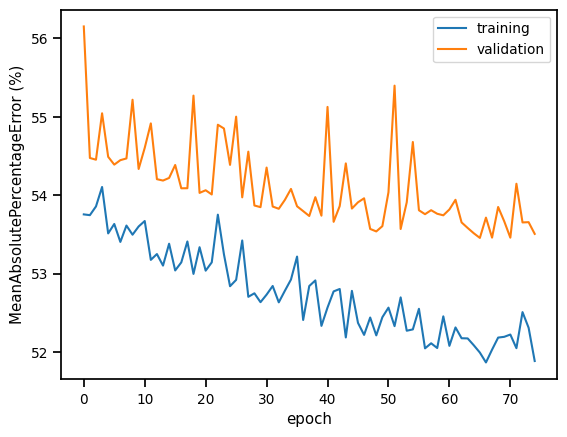

Evaluation Results: 51.00905227661133


In [100]:
#Using hyperparameter tuning with the increased data

# keras tuner
tuner = kt.RandomSearch(
    lambda hp : build_fnn_model(hp, input_shape, output_shape),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir3',
    project_name='fnn_tuning'
)

# search for best hyperparameter with dataset
tuner.search(X_train3, y_train3, epochs=50, validation_data=(X_test3, y_test3))

# obtain best model
best_fnn_model = tuner.get_best_models(num_models=1)[0]

# print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters: ")
print(best_hyperparameters.values)

# train with best hyperparameters
history = best_fnn_model.fit(X_train3, y_train3, epochs=75, batch_size=32, validation_data=(X_test3, y_test3))

# on final epoch
print("Val MAPE on final epoch:")
print(history.history["val_mean_absolute_percentage_error"][-1])

# plot 
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.gca().set(xlabel="epoch", ylabel="MeanAbsolutePercentageError (%)")
plt.legend()
plt.show()

# evaluation results
evaluation_results = best_fnn_model.evaluate(X_eval3, y_eval3, verbose=0)
print("Evaluation Results:", evaluation_results[0])

As we can see from the plots of both the non-hyperparamter tuned and hyperparameter tuned model, that having more data introduced a lot of noise. The Additional Data model was able to achieve around 51-54% MAPE on unseen test data, while the hyper-parameter tuned model achieved around the same as well. 


### Classification

We will try classification by re-encoding the target variable as a categorical one and updating our FNN model to match with a softmax layer and an output shape of (9, ).

In [103]:
temp_df

,Lifetime Gross,rating,score,votes,budget,runtime,years_since_oldest
0,218843645.0,0.571429,0.811111,0.022500,0.050562,0.572139,0.964706
2,218791811.0,0.714286,0.866667,0.180000,0.154494,0.666667,0.894118
3,218613188.0,0.571429,0.788889,0.050833,0.196629,0.492537,0.717647
4,218340595.0,0.714286,0.777778,0.132083,0.168539,0.646766,0.882353
5,218237071.0,1.000000,0.800000,0.113333,0.365169,0.716418,0.800000
...,...,...,...,...,...,...,...
1037,585410052.0,0.714286,0.800000,0.293333,0.421348,0.502488,0.823529
1038,579723768.0,0.285714,0.900000,0.349167,0.323034,0.457711,0.752941
1048,574482479.0,0.571429,0.711111,0.134583,0.308989,0.537313,0.811765
1049,569651467.0,1.000000,0.455556,0.126667,0.112360,0.621891,0.917647


In [104]:
class_df = temp_df.copy()

In [105]:
class_df['Lifetime Gross'] = (round(class_df['Lifetime Gross'] / 1e6))

In [106]:
bins = [140.0, 180.0, 220, 260, 300, 340, 380, 420, 460, 500, np.inf]
labels = ['< 140', '140-180', '180-220', '220-260', '260-300', '300-340', '340-380', '380-420', '420-460', '> 460']
class_df['Gross Range'] = pd.cut(class_df['Lifetime Gross'], bins = bins, labels = labels, right = True)

In [107]:
class_df = class_df.drop("Lifetime Gross", axis = 1)
class_df

,rating,score,votes,budget,runtime,years_since_oldest,Gross Range
0,0.571429,0.811111,0.022500,0.050562,0.572139,0.964706,140-180
2,0.714286,0.866667,0.180000,0.154494,0.666667,0.894118,140-180
3,0.571429,0.788889,0.050833,0.196629,0.492537,0.717647,140-180
4,0.714286,0.777778,0.132083,0.168539,0.646766,0.882353,140-180
5,1.000000,0.800000,0.113333,0.365169,0.716418,0.800000,140-180
...,...,...,...,...,...,...,...
1037,0.714286,0.800000,0.293333,0.421348,0.502488,0.823529,> 460
1038,0.285714,0.900000,0.349167,0.323034,0.457711,0.752941,> 460
1048,0.571429,0.711111,0.134583,0.308989,0.537313,0.811765,> 460
1049,1.000000,0.455556,0.126667,0.112360,0.621891,0.917647,> 460


In [108]:
X = class_df.drop("Gross Range", axis = 1)
y = class_df["Gross Range"].astype('category').cat.codes - 1

#Get evaluation set (X_eval, y_eval)
X_training, X_eval, y_training, y_eval = train_test_split(X, y, test_size = 0.1)

#training and validation set
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size = 0.2)

In [109]:
y.unique()

array([0, 2, 1, 4, 3, 8, 7, 6, 5], dtype=int8)

In [110]:
def construct_fnn(input_shape, output_shape):
    '''
    construct a fully connected neural network

    Parameters
    ----------
    input_shape : user-supplied input shape
    output_shape : user-supplied output shape

    Returns
    -------
    the constructed model
    '''
    FNN_model = tf.keras.models.Sequential([
    layers.Dense(64, input_shape = (input_shape,), activation='relu', kernel_initializer='he_normal'),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal'), 
    layers.Dense(output_shape),
    layers.Softmax(),
    ],
    name = "FNN_Model_class",
    )
    return FNN_model

In [111]:
input_shape = 6

output_shape = 9
#call the function
FNN_model = construct_fnn(input_shape, output_shape)

In [112]:
adam = keras.optimizers.Adam(
        learning_rate=0.03,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
)

    
# Define loss function 
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Compile model
FNN_model.compile(optimizer=adam,
              loss=loss_fn,
              metrics=['accuracy'])

# Train the model and return the history
history = FNN_model.fit(X_train, y_train, 
                    epochs= 75, 
                    batch_size= 32, 
                    validation_data=(X_test, y_test), 
                    verbose=False,
                       )

Val accuracy on final epoch:
0.2715231776237488 



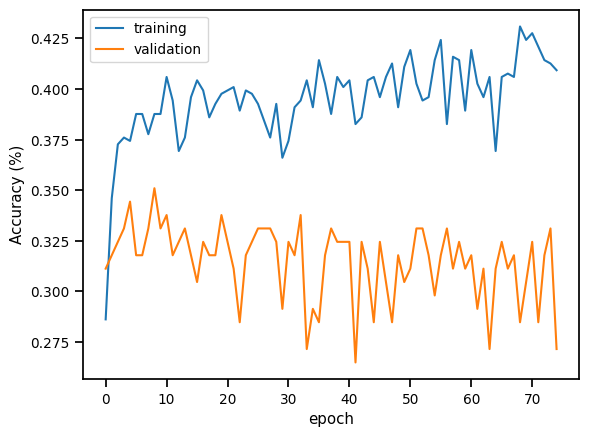

In [113]:
print("Val accuracy on final epoch:")
print(history.history["val_accuracy"][-1], "\n")

plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "Accuracy (%)")
plt.legend()
plt.show()

In [114]:
FNN_model.evaluate(X_eval, y_eval)[1]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2993 - loss: 1.8468 


0.3095238208770752

We were able to achieve around 30-40% accuracy meaning that the model was able to predict the exact bin 30%-40% of the time. 